In [1]:
pip install python-gdcm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 35.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# !pip install pydicom
import pandas as pd
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt

import os
import cv2
import glob
import gdcm
import pydicom
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from joblib import Parallel, delayed

from imblearn.over_sampling import SMOTE

import pickle 

import os
import cv2

from sklearn.utils import shuffle
from tqdm import tqdm

# !pip install pylibjpeg
# import pylibjpeg

import warnings
warnings.filterwarnings('ignore')

from skimage import transform

In [3]:
# Meta Data Import
train_df=pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')

# Get image path
# Example path: '/kaggle/input/rsna-breast-cancer-detection/train_images/10706/763186195.dcm'
base_path = "/kaggle/input/rsna-breast-cancer-detection/train_images/"
all_paths = []
for k in tqdm(range(len(train_df))):
    row = train_df.iloc[k, :]
    all_paths.append(base_path + str(row.patient_id) + "/" + str(row.image_id) + ".dcm")
    
train_df["path"] = all_paths
train_df.head()

100%|██████████| 54706/54706 [00:09<00:00, 6063.99it/s]


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-detection/tra...


In [4]:
train_df['biopsy'].value_counts()

0    51737
1     2969
Name: biopsy, dtype: int64

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
 14  path                  

In [6]:
train_df['patient_id'].nunique()

11913

# Build the training dataset

In [7]:
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-detection/tra...


## Check if a single patient xray has cancer in both breasts or only in one

In [8]:
train_df[train_df['cancer']==1]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
87,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
88,1,10130,613462606,L,CC,71.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
89,1,10130,1360338805,L,CC,71.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
90,1,10130,1672636630,L,MLO,71.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
190,1,10226,461614796,L,MLO,71.0,1,1,1,0.0,0,C,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54485,2,9707,1900919592,R,MLO,56.0,1,1,1,NaN,0,NaN,21,False,/kaggle/input/rsna-breast-cancer-detection/tra...
54593,2,9840,111786935,R,MLO,59.0,1,1,1,NaN,0,NaN,21,False,/kaggle/input/rsna-breast-cancer-detection/tra...
54594,2,9840,1559360810,R,CC,59.0,1,1,1,NaN,0,NaN,21,False,/kaggle/input/rsna-breast-cancer-detection/tra...
54595,2,9851,1409270544,L,MLO,58.0,1,1,0,NaN,0,NaN,48,False,/kaggle/input/rsna-breast-cancer-detection/tra...


In [9]:
train_df[train_df['patient_id']==9840]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
54591,2,9840,87146266,L,MLO,59.0,0,1,0,NaN,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-detection/tra...
54592,2,9840,629749649,L,CC,59.0,0,1,0,NaN,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-detection/tra...
54593,2,9840,111786935,R,MLO,59.0,1,1,1,NaN,0,NaN,21,False,/kaggle/input/rsna-breast-cancer-detection/tra...
54594,2,9840,1559360810,R,CC,59.0,1,1,1,NaN,0,NaN,21,False,/kaggle/input/rsna-breast-cancer-detection/tra...


> we can see for patient id 9840, she has cancer in right breast only

## Check how many images have cancer

In [10]:
train_df['cancer'].value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

## Build a data set of by sampling random number of patients with and without cancer

In [11]:
majority_class_df=train_df[train_df['cancer'] == 0].sample(200)
minority_class_df=train_df[train_df['cancer'] == 1].sample(400)

final_df = pd.concat([majority_class_df, minority_class_df])

final_df=final_df.reset_index(drop=True)
final_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,41557,754124152,R,MLO,71.0,0,0,0,NaN,0,B,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
1,2,64890,1263883233,L,MLO,72.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
2,2,33039,1045484143,L,MLO,63.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
3,1,24671,38405724,R,MLO,65.0,0,1,0,0.0,0,D,49,True,/kaggle/input/rsna-breast-cancer-detection/tra...
4,1,40548,1374423447,R,MLO,63.0,0,0,0,1.0,0,C,93,False,/kaggle/input/rsna-breast-cancer-detection/tra...


## Split the images into training data sets
-> Make 2 folders
* 0: Healthy Patients 
* 1: Cancer Patients 

In [12]:
import os
import pydicom
import cv2
import concurrent.futures
from tqdm import tqdm

output_folder = "/kaggle/working/train_images"

# Create healthy and cancer sub-folders inside output_folder
healthy_folder = os.path.join(output_folder, "healthy")
if not os.path.exists(healthy_folder):
    os.makedirs(healthy_folder)

cancer_folder = os.path.join(output_folder, "cancer")
if not os.path.exists(cancer_folder):
    os.makedirs(cancer_folder)

def process_image(row):
    src_path = row['path']
    patient_id = row['patient_id']
    image_id = row['image_id']

    # Load the DICOM image
    dicom = pydicom.dcmread(src_path)
    
    img = dicom.pixel_array
    img = (img - img.min()) / (img.max() - img.min())
    img = cv2.resize(img, (256, 256))
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        img = 1 - img

    # Determine the target folder based on the cancer column value
    if row['cancer'] == 0:
        target_folder = healthy_folder
    else:
        target_folder = cancer_folder

    # Construct the target path
    target_path = os.path.join(target_folder, f"{patient_id}_{image_id}.png")

    # Save the image to the target folder
    cv2.imwrite(target_path, (img * 255).astype(np.uint8))

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_image, row) for index, row in final_df.iterrows()]
    for f in tqdm(concurrent.futures.as_completed(futures), total=final_df.shape[0]):
        pass

100%|██████████| 600/600 [06:29<00:00,  1.54it/s]


## Count images in sub folders

In [13]:
# def show_folder_contents(folder_path):
#     for filename in os.listdir(folder_path):
#         print(filename)

# folder_path = "/kaggle/working/train_images/cancer"
# show_folder_contents(folder_path)

In [14]:
import os

def count_images(folder_path):
    count = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            count += 1
    return count

folder_path = "/kaggle/working/train_images/cancer"
image_count = count_images(folder_path)
print("Number of images in cancer folder:", image_count)

folder_path = "/kaggle/working/train_images/healthy"
image_count = count_images(folder_path)
print("Number of images in healthy folder:", image_count)

Number of images in cancer folder: 400
Number of images in healthy folder: 200


## View images in subfolder

In [15]:
import os
import matplotlib.pyplot as plt
    
def view_images_in_both_subfolders(folder_path, num_images=5):
    fig, ax = plt.subplots(nrows=2, ncols=num_images, figsize=(20, 10))
    class_folders = ["healthy", "cancer"]
#     class_folders = ["healthy_corrected", "cancer_corrected"]
    for j, class_folder in enumerate(class_folders):
        class_folder_path = os.path.join(folder_path, class_folder)
        file_names = os.listdir(class_folder_path)
        
        for i, file_name in enumerate(file_names[:num_images]):
                image = plt.imread(os.path.join(class_folder_path, file_name))
                ax[j, i].imshow(image, cmap='jet')
                ax[j, i].set_title(f"{class_folder} - Image Shape: {image.shape}")

    plt.show();

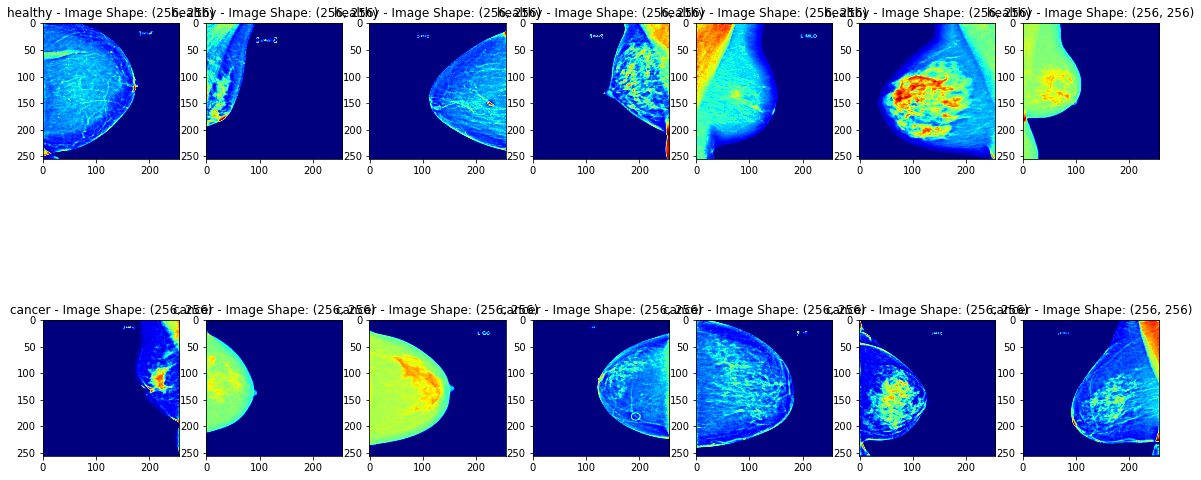

In [16]:
view_images_in_both_subfolders("/kaggle/working/train_images", num_images=7)

In [17]:
# def normalize_image(img):
#     img = img / np.max(img)
#     return img

# def normalize_folder(folder_path):
#     for subdir, dirs, files in os.walk(folder_path):
#         for file in files:
#             file_path = os.path.join(subdir, file)
#             img = cv2.imread(file_path, 0)
#             img = normalize_image(img)
#             cv2.imwrite(file_path, img)

# healthy_folder = "/kaggle/working/train_images/healthy"
# cancer_folder = "/kaggle/working/train_images/cancer"

# normalize_folder(healthy_folder)
# normalize_folder(cancer_folder)

In [18]:
def check_normalization(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if np.min(img) < 0 or np.max(img) > 1:
            print("Image not normalized:", np.min(img), np.max(img), img.shape, file_path)
        else:
            print("Image normalized:", np.min(img), np.max(img), img.shape, file_path)

# folder_path = "/kaggle/working/train_images/cancer"
# print('Cancer images check ===========')
# check_normalization(folder_path)

# folder_path = "/kaggle/working/train_images/healthy"
# print('\nHealthy images check ===========')
# check_normalization(folder_path)

# Preprocess the images

### Read nth image in a folder

In [19]:
def read_nth_image(folder_path, n):
    images = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    if len(images) < n:
        return None
    else:
        image_path = os.path.join(folder_path, images[n-1])
        image = cv2.imread(image_path)
        return image

In [20]:
folder_path='/kaggle/working/train_images/cancer/'
n=4
img=read_nth_image(folder_path, n)

In [21]:
img.shape, img.min(), img.max()

((256, 256, 3), 0, 255)

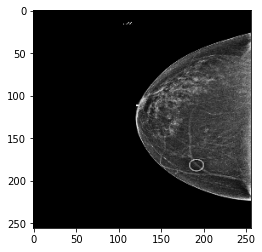

In [22]:
plt.imshow(img, cmap='gray');

### Apply preprocessing to just 1 image to see the changes

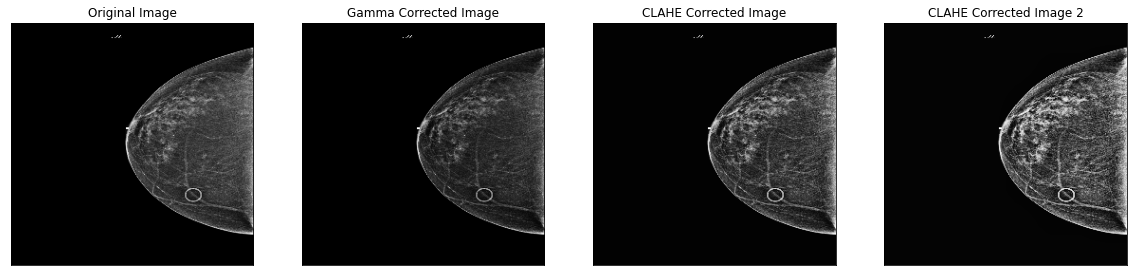

In [23]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)], dtype="uint8")

    # split the image into its three color channels (R, G, B)
    R, G, B = cv2.split(image)
    
    # apply gamma correction to each color channel
    corrected_R = cv2.LUT(R, table)
    corrected_G = cv2.LUT(G, table)
    corrected_B = cv2.LUT(B, table)
    
    # merge the corrected color channels back into a single image
    corrected_image = cv2.merge((corrected_R, corrected_G, corrected_B))
    
    return corrected_image

def apply_clahe(img, clip_limit=2.0, tile_grid_size=(8,8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    
    # split the image into its three color channels (R, G, B)
    R, G, B = cv2.split(img)
    
    # apply CLAHE to each color channel
    cl1_R = clahe.apply(R)
    cl1_G = clahe.apply(G)
    cl1_B = clahe.apply(B)
    
    # merge the corrected color channels back into a single image
    cl1 = cv2.merge((cl1_R, cl1_G, cl1_B))
    
    return cl1

# Perform gamma correction with gamma=0.5
gamma_corrected_image = adjust_gamma(img, 0.8)

# Apply CLAHE
clahe_corrected_image = apply_clahe(gamma_corrected_image, clip_limit=1.0, tile_grid_size=(8,8))

# Apply CLAHE
clahe_corrected_image_2 = apply_clahe(clahe_corrected_image, clip_limit=1.0, tile_grid_size=(8,8))

# Display original, gamma corrected, and CLAHE corrected images
plt.figure(figsize=(20,8))
plt.subplot(1,4,1),plt.imshow(img,cmap="gray")
plt.title("Original Image"), plt.xticks([]), plt.yticks([])

plt.subplot(1,4,2),plt.imshow(gamma_corrected_image,cmap="gray")
plt.title("Gamma Corrected Image"), plt.xticks([]), plt.yticks([])

plt.subplot(1,4,3),plt.imshow(clahe_corrected_image,cmap="gray")
plt.title("CLAHE Corrected Image"), plt.xticks([]), plt.yticks([])

plt.subplot(1,4,4),plt.imshow(clahe_corrected_image_2,cmap="gray")
plt.title("CLAHE Corrected Image 2"), plt.xticks([]), plt.yticks([])

plt.show()

### Define preprocessing functions to modify the images in the target fodlers 

In [24]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)], dtype="uint8")

    # split the image into its three color channels (R, G, B)
    R, G, B = cv2.split(image)
    
    # apply gamma correction to each color channel
    corrected_R = cv2.LUT(R, table)
    corrected_G = cv2.LUT(G, table)
    corrected_B = cv2.LUT(B, table)
    
    # merge the corrected color channels back into a single image
    corrected_image = cv2.merge((corrected_R, corrected_G, corrected_B))
    
    return corrected_image

def apply_clahe(img, clip_limit=2.0, tile_grid_size=(8,8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    
    # split the image into its three color channels (R, G, B)
    R, G, B = cv2.split(img)
    
    # apply CLAHE to each color channel
    cl1_R = clahe.apply(R)
    cl1_G = clahe.apply(G)
    cl1_B = clahe.apply(B)
    
    # merge the corrected color channels back into a single image
    cl1 = cv2.merge((cl1_R, cl1_G, cl1_B))
    
    return cl1

cancer_folder = "/kaggle/working/train_images/cancer/"
healthy_folder = "/kaggle/working/train_images/healthy/"

def process_images(folder_path):
    for filename in os.listdir(folder_path):
        print(os.path.join(folder_path, filename))
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            image = cv2.imread(os.path.join(folder_path, filename))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert from BGR to RGB
            image = adjust_gamma(image)
            image = apply_clahe(image)
            image = apply_clahe(image)
            cv2.imwrite(os.path.join(folder_path, filename), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

In [25]:
process_images(cancer_folder)
process_images(healthy_folder)

/kaggle/working/train_images/cancer/17222_637984831.png
/kaggle/working/train_images/cancer/62996_1021429436.png
/kaggle/working/train_images/cancer/8248_454443523.png
/kaggle/working/train_images/cancer/7780_132778066.png
/kaggle/working/train_images/cancer/51609_494727154.png
/kaggle/working/train_images/cancer/51498_1481006643.png
/kaggle/working/train_images/cancer/38727_1338411990.png
/kaggle/working/train_images/cancer/46225_1857969319.png
/kaggle/working/train_images/cancer/18026_1905432390.png
/kaggle/working/train_images/cancer/5878_872782383.png
/kaggle/working/train_images/cancer/57623_1317268595.png
/kaggle/working/train_images/cancer/41610_1957729736.png
/kaggle/working/train_images/cancer/50600_772542553.png
/kaggle/working/train_images/cancer/44780_1918822736.png
/kaggle/working/train_images/cancer/48230_386832097.png
/kaggle/working/train_images/cancer/17535_952275239.png
/kaggle/working/train_images/cancer/37032_1291044944.png
/kaggle/working/train_images/cancer/25423_

In [26]:
folder_path = "/kaggle/working/train_images/cancer"
image_count = count_images(folder_path)
print("Number of images in cancer folder:", image_count)


folder_path = "/kaggle/working/train_images/healthy"
image_count = count_images(folder_path)
print("Number of images in healthy folder:", image_count)

Number of images in cancer folder: 400
Number of images in healthy folder: 200


# Baseline CNN Model

In [27]:
import tensorflow as tf
tf.config.threading.set_inter_op_parallelism_threads(4)

## Augment the data

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.transform import rotate
from sklearn.metrics import roc_auc_score

# set the seed
tf.random.set_seed(42)

# set path to data directory
train_dir='/kaggle/working/train_images'

train_data = ImageDataGenerator(
                                # set data augmentation parameters
#                                 preprocessing_function=custom_augmentation,
                                rescale=1./255,
                                rotation_range=45,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest'
).flow_from_directory(
                      directory=train_dir,
                      batch_size=16,
                      target_size=(256,256),
                      color_mode='rgb',
                      class_mode='binary',
                      seed=42
                    )

Found 600 images belonging to 2 classes.


## Run the CNN Model

In [29]:
# 1. Basic Model
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Reshape((256, 256, 3), input_shape=(256, 256, 3)),
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, 
                         activation="relu"), 
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2), 
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), 
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") 
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# split the data into training and validation sets
val_split = 0.2
x_data, y_data = [], []
for x, y in train_data:
    x_data.append(x)
    y_data.append(y)
    if len(x_data) >= (1 - val_split) / train_data.batch_size:
        break
x_train = np.concatenate(x_data)
y_train = np.concatenate(y_data)
x_val = next(train_data)[0]
y_val = next(train_data)[1]

# fit the model using the training data
history_1 = model_1.fit(x_train, y_train,
                        epochs=100,
                        validation_data=(x_val, y_val))

# evaluate the model on the validation data
val_loss, val_acc = model_1.evaluate(x_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

# calculate AUC score
y_pred = model_1.predict(x_val)
auc = roc_auc_score(y_val, y_pred)
print("AUC Score:", auc)

2023-02-12 09:55:01.336110: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.6930 - accuracy: 0.5625 - val_loss: 0.6446 - val_accuracy: 0.6250
Epoch 2/100
1/1 [==============================] - 0s 315ms/step - loss: 0.5842 - accuracy: 0.7500 - val_loss: 0.7138 - val_accuracy: 0.6250
Epoch 3/100
1/1 [==============================] - 0s 299ms/step - loss: 0.5745 - accuracy: 0.7500 - val_loss: 0.7098 - val_accuracy: 0.6250
Epoch 4/100
1/1 [==============================] - 0s 309ms/step - loss: 0.5373 - accuracy: 0.7500 - val_loss: 0.6725 - val_accuracy: 0.6250
Epoch 5/100
1/1 [==============================] - 0s 304ms/step - loss: 0.5025 - accuracy: 0.7500 - val_loss: 0.6546 - val_accuracy: 0.6250
Epoch 6/100
1/1 [==============================] - 0s 314ms/step - loss: 0.4720 - accuracy: 0.7500 - val_loss: 0.6584 - val_accuracy: 0.6250
Epoch 7/100
1/1 [==============================] - 0s 299ms/step - loss: 0.4390 - accuracy: 0.7500 - val_loss: 0.6838 - val_accuracy: 0.6250
Epoch 8/100
1/1 

# VGG16 Model

In [30]:
# from tensorflow.keras.applications import VGG16


# # Load the VGG16 model, excluding the top layer
# vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# # Freeze all layers of the VGG16 model
# for layer in vgg16_model.layers:
#     layer.trainable = False

# # Create a new sequential model
# model = tf.keras.models.Sequential()

# # Add the pre-trained VGG16 model to the new sequential model
# model.add(vgg16_model)

# # Add a new Flatten layer to the new sequential model
# model.add(tf.keras.layers.Flatten())

# # Add a new dense layer with 1024 neurons and ReLU activation to the new sequential model
# model.add(tf.keras.layers.Dense(1024, activation='relu'))

# # Add a new dense layer with 1 neuron and sigmoid activation to the new sequential model
# model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# # Compile the model
# model.compile(loss="binary_crossentropy",
#               optimizer=tf.keras.optimizers.Adam(),
#               metrics=["accuracy"])

# # Fit the model using the training data
# history = model.fit(x_train, y_train,
#                     epochs=100,
#                     validation_data=(x_val, y_val))

# # Evaluate the model on the validation data
# val_loss, val_acc = model.evaluate(x_val, y_val)
# print("Validation Loss:", val_loss)
# print("Validation Accuracy:", val_acc)


# Xception Model

In [31]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Dropout

# Load the Xception model, excluding the top layer
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(256,256,3))

# Freeze all layers of the Xception model
for i, layer in enumerate(xception_model.layers):
    if i >= 5:  # change this number to select the layer index to start unfreezing from
        layer.trainable = True

# Create a new sequential model
model = tf.keras.models.Sequential()

# Add the pre-trained Xception model to the new sequential model
model.add(xception_model)

# Add a new Flatten layer to the new sequential model
model.add(tf.keras.layers.Flatten())

# Add a new dense layer with 1024 neurons and ReLU activation to the new sequential model
model.add(tf.keras.layers.Dense(1024, activation='relu',
                                kernel_regularizer=l2(0.01)))

# Add a dropout layer with a rate of 0.5
model.add(Dropout(0.5))

# Add a new dense layer with 1 neuron and sigmoid activation to the new sequential model
model.add(tf.keras.layers.Dense(1, activation='sigmoid',
                                kernel_regularizer=l2(0.01)))

# Compile the model
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
              metrics=["accuracy"])

# Fit the model using the training data
history = model.fit(x_train, y_train,
                    epochs=10,
                    validation_data=(x_val, y_val))

# Evaluate the model on the validation data
val_loss, val_acc = model.evaluate(x_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

# calculate AUC score
y_pred = model_1.predict(x_val)
auc = roc_auc_score(y_val, y_pred)
print("AUC Score:", auc)

83697664/83683744 [==============================] - 1s 0us/step
Epoch 1/10
1/1 [==============================] - 17s 17s/step - loss: 21.2021 - accuracy: 0.3750 - val_loss: 22.6368 - val_accuracy: 0.6250
Epoch 2/10
1/1 [==============================] - 8s 8s/step - loss: 21.1366 - accuracy: 0.7500 - val_loss: 22.3948 - val_accuracy: 0.6250
Epoch 3/10
1/1 [==============================] - 8s 8s/step - loss: 20.4726 - accuracy: 0.8750 - val_loss: 21.6963 - val_accuracy: 0.6875
Epoch 4/10
1/1 [==============================] - 8s 8s/step - loss: 20.3335 - accuracy: 1.0000 - val_loss: 21.7334 - val_accuracy: 0.3125
Epoch 5/10
1/1 [==============================] - 8s 8s/step - loss: 20.2993 - accuracy: 1.0000 - val_loss: 22.1435 - val_accuracy: 0.4375
Epoch 6/10
1/1 [==============================] - 8s 8s/step - loss: 20.2712 - accuracy: 1.0000 - val_loss: 22.4473 - val_accuracy: 0.4375
Epoch 7/10
1/1 [==============================] - 8s 8s/step - loss: 20.2471 - accuracy: 1.0000 - v

# Inception-v3 Model

In [32]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint

# Load the Inception-v3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze all layers of the Inception-v3 model
for i, layer in enumerate(base_model.layers):
    if i >= 30:  # change this number to select the layer index to start unfreezing from
        layer.trainable = True

# Create a new sequential model
model = tf.keras.models.Sequential()

# Add the pre-trained Inception-v3 model to the new sequential model
model.add(base_model)

# Add a new GlobalAveragePooling2D layer to the new sequential model
model.add(GlobalAveragePooling2D())

# Add a new dense layer with 2048 neurons and ReLU activation to the new sequential model
model.add(Dense(2048, activation='relu'))

# Add a dropout layer with a rate of 0.5
model.add(Dropout(0.5))

# Add a new dense layer with 1 neuron and sigmoid activation to the new sequential model
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

# Model checkpoint
checkpoint = ModelCheckpoint('model.h5', save_best_only=True)

# Fit the model using the training data
history = model.fit(x_train, y_train,
                    epochs=10,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint])

# # Load the best model
# model = tf.keras.models.load_model('model.h5')

# Evaluate the model on the validation data
val_loss, val_acc = model.evaluate(x_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

# Calculate the AUC score
y_pred = model.predict(x_val)
auc = roc_auc_score(y_val, y_pred)
print("AUC Score:", auc)


87924736/87910968 [==============================] - 1s 0us/step
Epoch 1/10
1/1 [==============================] - 16s 16s/step - loss: 0.7700 - accuracy: 0.5625 - val_loss: 7.2130 - val_accuracy: 0.6250
Epoch 2/10
1/1 [==============================] - 5s 5s/step - loss: 2.5719 - accuracy: 0.7500 - val_loss: 9.8605 - val_accuracy: 0.6250
Epoch 3/10
1/1 [==============================] - 5s 5s/step - loss: 0.2991 - accuracy: 0.7500 - val_loss: 11.2559 - val_accuracy: 0.6250
Epoch 4/10
1/1 [==============================] - 5s 5s/step - loss: 0.1707 - accuracy: 1.0000 - val_loss: 11.5072 - val_accuracy: 0.6250
Epoch 5/10
1/1 [==============================] - 5s 5s/step - loss: 0.0740 - accuracy: 1.0000 - val_loss: 12.4851 - val_accuracy: 0.6250
Epoch 6/10
1/1 [==============================] - 5s 5s/step - loss: 0.0390 - accuracy: 1.0000 - val_loss: 14.5078 - val_accuracy: 0.6250
Epoch 7/10
1/1 [==============================] - 5s 5s/step - loss: 0.0770 - accuracy: 1.0000 - val_loss: 

# Applying Model on Test Dataset

In [33]:
result_df = train_df[~train_df['path'].isin(final_df['path'])]
result_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-detection/tra...


In [34]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54106 entries, 0 to 54705
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54106 non-null  int64  
 1   patient_id               54106 non-null  int64  
 2   image_id                 54106 non-null  int64  
 3   laterality               54106 non-null  object 
 4   view                     54106 non-null  object 
 5   age                      54069 non-null  float64
 6   cancer                   54106 non-null  int64  
 7   biopsy                   54106 non-null  int64  
 8   invasive                 54106 non-null  int64  
 9   BIRADS                   25966 non-null  float64
 10  implant                  54106 non-null  int64  
 11  density                  29139 non-null  object 
 12  machine_id               54106 non-null  int64  
 13  difficult_negative_case  54106 non-null  bool   
 14  path                  

In [35]:
majority_class_df=result_df[result_df['cancer'] == 0].sample(100)
minority_class_df=result_df[result_df['cancer'] == 1].sample(100)

final_df_test = pd.concat([majority_class_df, minority_class_df])

final_df_test=final_df_test.reset_index(drop=True)
final_df_test.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,1,60292,494258064,R,CC,48.0,0,0,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-detection/tra...
1,1,38036,1576207623,R,MLO,80.0,0,0,0,1.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
2,2,50637,800281218,L,CC,71.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
3,1,37847,796237040,L,CC,55.0,0,0,0,0.0,0,C,49,True,/kaggle/input/rsna-breast-cancer-detection/tra...
4,1,53317,1943485239,L,CC,61.0,0,0,0,1.0,0,C,93,False,/kaggle/input/rsna-breast-cancer-detection/tra...


In [36]:
output_folder = "/kaggle/working/test_images"

# Create healthy and cancer sub-folders inside output_folder
healthy_folder = os.path.join(output_folder, "healthy")
if not os.path.exists(healthy_folder):
    os.makedirs(healthy_folder)

cancer_folder = os.path.join(output_folder, "cancer")
if not os.path.exists(cancer_folder):
    os.makedirs(cancer_folder)


with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_image, row) for index, row in final_df_test.iterrows()]
    for f in tqdm(concurrent.futures.as_completed(futures), total=final_df_test.shape[0]):
        pass

100%|██████████| 200/200 [02:14<00:00,  1.49it/s]


In [37]:
cancer_folder='/kaggle/working/test_images/cancer'
healthy_folder='/kaggle/working/test_images/healthy'

process_images(cancer_folder)
process_images(healthy_folder)

/kaggle/working/test_images/cancer/51697_1244710301.png
/kaggle/working/test_images/cancer/27275_1280544598.png
/kaggle/working/test_images/cancer/6107_2145202604.png
/kaggle/working/test_images/cancer/60410_1597116280.png
/kaggle/working/test_images/cancer/63053_1922119353.png
/kaggle/working/test_images/cancer/31582_564250417.png
/kaggle/working/test_images/cancer/9559_203061242.png
/kaggle/working/test_images/cancer/46095_2141709197.png
/kaggle/working/test_images/cancer/57216_1322452138.png
/kaggle/working/test_images/cancer/39677_1816604050.png
/kaggle/working/test_images/cancer/32527_701842729.png
/kaggle/working/test_images/cancer/61568_965929379.png
/kaggle/working/test_images/cancer/53343_1721695713.png
/kaggle/working/test_images/cancer/12725_1297379916.png
/kaggle/working/test_images/cancer/4824_1764642297.png
/kaggle/working/test_images/cancer/34962_4612225.png
/kaggle/working/test_images/cancer/4696_2042369465.png
/kaggle/working/test_images/cancer/5608_1085496456.png
/kag

In [38]:
cancer_folder='/kaggle/working/test_images/cancer'
healthy_folder='/kaggle/working/test_images/healthy'

cancer = count_images(cancer_folder)
print("Number of images in cancer folder:", cancer)

healthy = count_images(healthy_folder)
print("Number of images in healthy folder:", healthy)

Number of images in cancer folder: 100
Number of images in healthy folder: 100


In [39]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np

# Load the model
model = tf.keras.models.load_model('model.h5')

# Define the folder containing the test images
cancer_folder = '/kaggle/working/test_images/cancer'

# Define a variable to store the number of cancer predictions
cancer_predictions = 0

# Loop through the images in the folder
for img in os.listdir(cancer_folder):
    # Load the image
    img_path = os.path.join(cancer_folder, img)
    img = image.load_img(img_path, target_size=(256, 256))

    # Preprocess the image
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Make a prediction on the image
    pred = model.predict(x)
    pred = pred[0][0]

    # Increment the number of cancer predictions if the prediction is greater than 0.5
    if pred > 0.5:
        cancer_predictions += 1

    # Print the prediction
    print("Prediction for image", img, ":", pred)

# Calculate the percentage of total cancer predictions
total_predictions = len(os.listdir(cancer_folder))
percentage_cancer_predictions = cancer_predictions / total_predictions * 100

# Print the percentage of total cancer predictions
print("Percentage of total cancer predictions:", percentage_cancer_predictions, "%")

Prediction for image <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7FB34C397F10> : 4.804908e-10
Prediction for image <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7FB12F505F10> : 1.5832308e-10
Prediction for image <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7FB34C392110> : 4.2542037e-09
Prediction for image <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7FB127898E50> : 1.7711908e-10
Prediction for image <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7FB347EA5A50> : 4.4499182e-11
Prediction for image <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7FB347ECE050> : 3.3610975e-10
Prediction for image <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7FB127898E50> : 1.8564505e-10
Prediction for image <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7FB34C3A1D10> : 1.345458e-10
Prediction for image <PIL.PngImagePlugin.PngImageFile image mode=R

# EXPERIMENTS

In [40]:
filter=(train_df['cancer']==1) & (train_df['biopsy']==1) & (train_df['density']=='A')
density_A=train_df[filter]

In [41]:
folder_path='/kaggle/working/train_images/cancer/'
n=8
img=read_nth_image(folder_path, n)

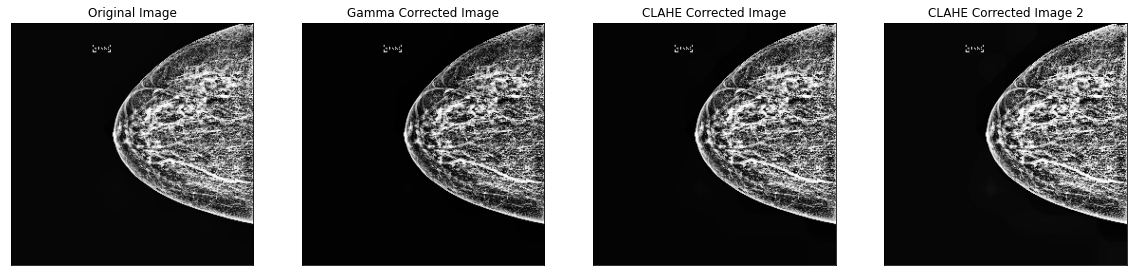

In [42]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)], dtype="uint8")

    # split the image into its three color channels (R, G, B)
    R, G, B = cv2.split(image)
    
    # apply gamma correction to each color channel
    corrected_R = cv2.LUT(R, table)
    corrected_G = cv2.LUT(G, table)
    corrected_B = cv2.LUT(B, table)
    
    # merge the corrected color channels back into a single image
    corrected_image = cv2.merge((corrected_R, corrected_G, corrected_B))
    
    return corrected_image

def apply_clahe(img, clip_limit=2.0, tile_grid_size=(8,8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    
    # split the image into its three color channels (R, G, B)
    R, G, B = cv2.split(img)
    
    # apply CLAHE to each color channel
    cl1_R = clahe.apply(R)
    cl1_G = clahe.apply(G)
    cl1_B = clahe.apply(B)
    
    # merge the corrected color channels back into a single image
    cl1 = cv2.merge((cl1_R, cl1_G, cl1_B))
    
    return cl1

# Perform gamma correction with gamma=0.5
gamma_corrected_image = adjust_gamma(img, 0.8)

# Apply CLAHE
clahe_corrected_image = apply_clahe(gamma_corrected_image, clip_limit=1.0, tile_grid_size=(8,8))

# Apply CLAHE
clahe_corrected_image_2 = apply_clahe(clahe_corrected_image, clip_limit=1.0, tile_grid_size=(8,8))

# Display original, gamma corrected, and CLAHE corrected images
plt.figure(figsize=(20,8))
plt.subplot(1,4,1),plt.imshow(img,cmap="gray")
plt.title("Original Image"), plt.xticks([]), plt.yticks([])

plt.subplot(1,4,2),plt.imshow(gamma_corrected_image,cmap="gray")
plt.title("Gamma Corrected Image"), plt.xticks([]), plt.yticks([])

plt.subplot(1,4,3),plt.imshow(clahe_corrected_image,cmap="gray")
plt.title("CLAHE Corrected Image"), plt.xticks([]), plt.yticks([])

plt.subplot(1,4,4),plt.imshow(clahe_corrected_image_2,cmap="gray")
plt.title("CLAHE Corrected Image 2"), plt.xticks([]), plt.yticks([])

plt.show()

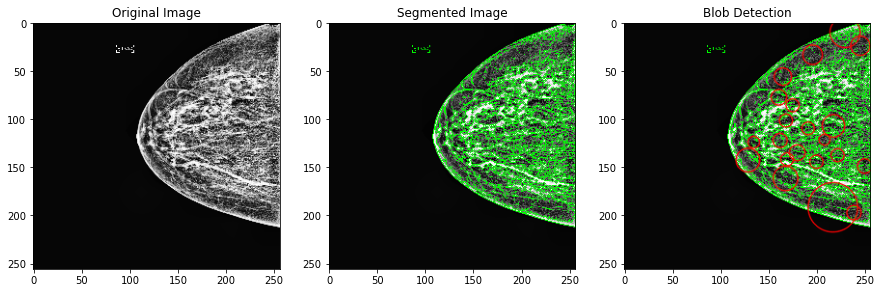

In [43]:
import cv2
import matplotlib.pyplot as plt

segmented = img.copy()

# Convert the image to grayscale
gray = cv2.cvtColor(segmented, cv2.COLOR_BGR2GRAY)

# Threshold the grayscale image to segment the breast tissue
_, thresholded = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

# Find the contours of the segmented breast tissue
contours, _ = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
cv2.drawContours(segmented, contours, -1, (0, 255, 0), 1)

blob = segmented.copy()

# Perform blob detection on the segmented mammogram
params = cv2.SimpleBlobDetector_Params()

# Adjust the parameters for better blob detection
params.minThreshold = 10
params.maxThreshold = 200
params.filterByArea = True
params.minArea = 100
params.filterByCircularity = False
params.filterByConvexity = False
params.filterByInertia = False

detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(blob)

# Draw the blobs on the segmented image
blob = cv2.drawKeypoints(blob, keypoints, np.array([]), (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the original image, segmented image, and image with blobs
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[1].imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
axs[1].set_title('Segmented Image')
axs[2].imshow(cv2.cvtColor(blob, cv2.COLOR_BGR2RGB))
axs[2].set_title('Blob Detection')
plt.show()


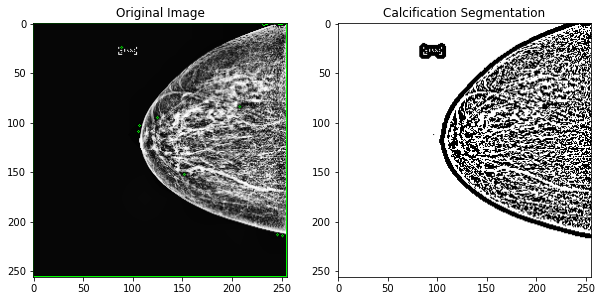

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply adaptive thresholding to segment the calcifications
thresholded = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# Dilate the thresholded image to fill in any holes in the segmentation
kernel = np.ones((5, 5), np.uint8)
dilation = cv2.dilate(thresholded, kernel, iterations=1)

# Find the contours of the segmented calcifications
contours, _ = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
img = cv2.drawContours(img, contours, -1, (0, 255, 0), 1)

# Display the original image and the image with calcification contours
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[1].imshow(thresholded, cmap='gray')
axs[1].set_title('Calcification Segmentation')
plt.show()

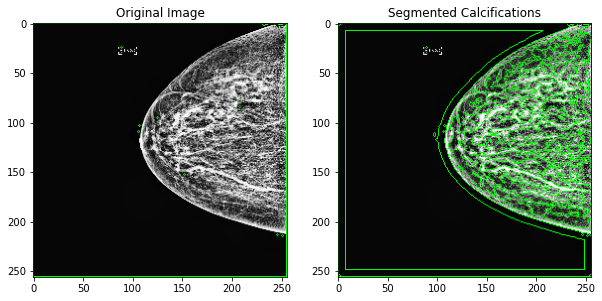

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply median filter to reduce noise
median = cv2.medianBlur(gray, 5)

# Apply adaptive thresholding to segment the calcifications
thresholded = cv2.adaptiveThreshold(median, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2)

# Find the contours of the segmented calcifications
contours, _ = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
segmented = img.copy()
cv2.drawContours(segmented, contours, -1, (0, 255, 0), 1)

# Display the original image and segmented image with calcifications
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[1].imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
axs[1].set_title('Segmented Calcifications')
plt.show()


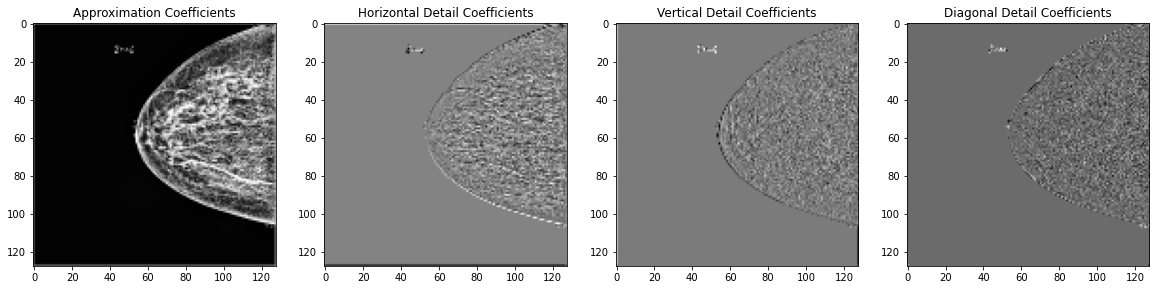

In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply the wavelet transform to the image
coeffs = pywt.dwt2(gray, 'haar')
cA, (cH, cV, cD) = coeffs

# Plot the coefficients
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(cA, cmap='gray')
axs[0].set_title('Approximation Coefficients')
axs[1].imshow(cH, cmap='gray')
axs[1].set_title('Horizontal Detail Coefficients')
axs[2].imshow(cV, cmap='gray')
axs[2].set_title('Vertical Detail Coefficients')
axs[3].imshow(cD, cmap='gray')
axs[3].set_title('Diagonal Detail Coefficients')
plt.show()


In [47]:
train_df[train_df['density']=='A']

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
510,1,10526,657541655,L,CC,57.0,0,0,0,2.0,0,A,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
511,1,10526,880953279,L,MLO,57.0,0,0,0,2.0,0,A,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
512,1,10526,376934385,R,CC,57.0,0,0,0,2.0,0,A,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
513,1,10526,1505027709,R,MLO,57.0,0,0,0,2.0,0,A,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
514,1,10526,1782974695,R,CC,57.0,0,0,0,2.0,0,A,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54574,1,9814,443154885,L,MLO,61.0,0,0,0,1.0,1,A,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
54575,1,9814,1064110749,L,CC,61.0,0,0,0,1.0,1,A,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
54576,1,9814,12369795,R,MLO,61.0,0,0,0,1.0,1,A,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
54577,1,9814,1149002441,R,CC,61.0,0,0,0,1.0,1,A,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
